In [1]:
import gym
from gym.spaces.utils import flatdim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

from minigrid.envs import FourRoomsEnv
import matplotlib.pyplot as plt
import graphviz
from copy import deepcopy
from collections import defaultdict

In [21]:

class FrozenLakeModel:
    def __init__(self, transitions):
        self.model = transitions

    def step(self, obs, action):
        _, next_obs, r, done =  self.model[obs][action][0]
        return next_obs, r, done, _
    
    def actions(self, obs):
        return list(self.model[obs].keys())

class Node:
    def __init__(self, state, action=None):
        self.state = state
        self.action = action
        self.reward = 0
        self.done = False

        self.parent = None
        self.children = {}

        self.value = 0.0
        self.visits = 0
    
    def __repr__(self):
        return f"Node: (s:{self.state}, a:{self.action}, r:{self.reward}, d:{self.done})"
    
    def update_stats(self, val):
        self.visits += 1
        self.value += (val - self.value) / float(self.visits)

class MCTS:
    def __init__(self, cur_state, model, hparams):
        self.cur_state = cur_state
        self.model = model
        self.iters: int = hparams["iters"]
        self.discount = 0.99 
        self.sim_depth = hparams.get("sim_depth", 1000)
    
    def search(self):
        root = Node(self.cur_state)
        print("Running MCTS.")
        for i in trange(self.iters):
            next_node = self._treePolicy(root)
            reward = self._rolloutPolicy(next_node)
            self._backup(next_node, reward)
        
        print("MCTS finished.")
        return self._best_action(root), root

    # "Most Robust Child" selection: http://www.incompleteideas.net/609%20dropbox/other%20readings%20and%20resources/MCTS-survey.pdf
    def _best_action(self, root):
        return max(root.children.values(), key = lambda child: child.visits).action

    # Tree Policy explores current tree up to edge.
    def _treePolicy(self, cur_node) -> Node:

        next_node = cur_node
        while not next_node.done:
            if not self._expanded(next_node):
                return self._expand(next_node)
            else:
                next_node = self._UCT(next_node)

        return next_node

    # Rollout policy performs random (or via some policy) rollouts til termination. Returns reward.
    def _rolloutPolicy(self, node: Node) -> float:
        
        cur_node = node
        done = False
        cum_reward = node.reward
        for _ in range(self.sim_depth):
            action = np.random.choice(self.model.actions(cur_node.state))
            next_obs, r, done, _ = self.model.step(cur_node.state, action) 

            cum_reward += r
            if done:
                break
                
            cur_node = Node(next_obs)
        return cum_reward

    def _UCT(self, node: Node) -> Node:
        children: list[Node] = list(node.children.values())
        weights = [child.value + 1.5 * np.sqrt(np.log(node.visits + 1e-6) / (child.visits + 1e-6)) for child in children]
        weights = np.array(weights) / sum(weights)
        return np.random.choice(children, p=weights)

    def _expanded(self, node: Node) -> bool:
        return set(self.model.actions(node.state)) == set(node.children.keys())

    def _expand(self, node: Node) -> Node:

        # Sample random action
        actions = self.model.actions(node.state)
        if (len(node.children.keys()) > 0):
            for performed in list(node.children.keys()):
                actions.remove(performed)

        action = np.random.choice(actions)

        next_obs, r, done, _ = self.model.step(node.state, action)

        # Construct new node
        next_node = Node(next_obs, action)
        next_node.parent = node
        next_node.reward = r
        next_node.done = done

        # Add to list of children
        node.children[action] = next_node

        return next_node



    def _backup(self, node: Node, reward: float) -> None:
        node.update_stats(reward)

        while node.parent:
            node = node.parent
            node.update_stats(self.discount * reward)

# For viz purposes
def unpack(root: Node, graph, ignore, action_map=None):
    if (not root.parent):
        graph.node(str(root.state))

    if len(root.children.values()) == 0:
        return graph
    
    for child in root.children.values():
        if (not (str(root.state), str(child.state), child.action) in ignore):
            graph.edge(str(root.state), str(child.state), label=str(child.action if not action_map else action_map[child.action]))
            ignore.add((str(root.state), str(child.state), child.action))

        graph = unpack(child, graph, ignore, action_map=action_map)
    
    return graph

# Visualize visitation frequency
def unpack_visits(root: Node, visit_freqs=defaultdict(lambda: 0)):
    if len(root.children.values()) == 0:
        visit_freqs[root.state] += root.visits
    
    for child in root.children.values():
        visit_freqs = unpack_visits(child, visit_freqs)
    
    return visit_freqs

In [35]:
env = gym.make("FrozenLake-v1", is_slippery=False)
model = FrozenLakeModel(env.P)
obs = env.reset()

action_map = {
    0: "LEFT",
    1: "DOWN", 
    2: "RIGHT",
    3: "UP"
}

obs = env.reset()
done = False
ep_r = 0
while not done:
    action, values = MCTS(obs, model, {"iters": 1000}).search()
    # print([(action_map[child.action], child.value) for child in values.children.values()])
    # print(f"Moving {action_map[action]}")
    obs, r, done, _ = env.step(action)
    ep_r += r

print(f"Episode return: {ep_r}")

Running MCTS.


100%|██████████| 1000/1000 [00:00<00:00, 1912.39it/s]


MCTS finished.
Running MCTS.


100%|██████████| 1000/1000 [00:00<00:00, 2588.23it/s]


MCTS finished.
Running MCTS.


100%|██████████| 1000/1000 [00:00<00:00, 2537.79it/s]


MCTS finished.
Running MCTS.


100%|██████████| 1000/1000 [00:00<00:00, 3668.38it/s]


MCTS finished.
Running MCTS.


100%|██████████| 1000/1000 [00:00<00:00, 3208.78it/s]


MCTS finished.
Running MCTS.


100%|██████████| 1000/1000 [00:00<00:00, 4600.42it/s]

MCTS finished.
Episode return: 1.0


In [36]:
obs = env.reset()
action, root = MCTS(obs, model, {"iters": 5000}).search()
graph = unpack(root, graphviz.Digraph(), set(), action_map=action_map)
graph.render("./frozen-lake/visit-tree", format="png")

Running MCTS.


100%|██████████| 5000/5000 [00:02<00:00, 2021.06it/s]


MCTS finished.


'frozen-lake/visit-tree.png'

100%|██████████| 64/64 [00:02<00:00, 31.52it/s]
/tmp/ipykernel_22483/1327094847.py:10: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(V.reshape(int(np.sqrt(nS)), int(np.sqrt(nS)))))


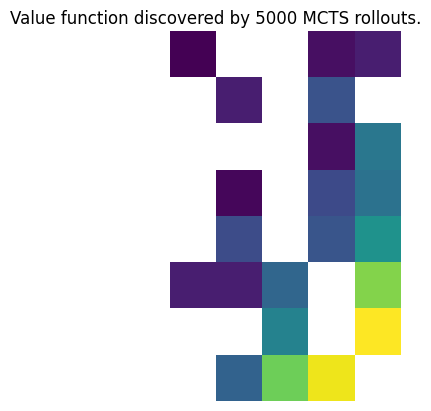

In [5]:
# MCTS estimated values in every state
env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False)
model = FrozenLakeModel(env.P)
nS = flatdim(env.observation_space)
V = np.zeros(nS)
for i in trange(env.observation_space.n):
    _, values = MCTS(i, model, {"iters": 100}).search()
    V[i] = np.mean([child.value for child in values.children.values()])

plt.imshow(np.log(V.reshape(int(np.sqrt(nS)), int(np.sqrt(nS)))))
plt.title("Value function discovered by 5000 MCTS rollouts.")
plt.axis("off")
plt.savefig("./frozen-lake/value-5000")

In [9]:
class FourRoomsModel:
    def __init__(self, goal_pos=(16,16), seed=42):
        self.goal_pos = goal_pos
        self.seed = seed

    def step(self, agent_state, action) -> tuple[_, float]:
        agent_pos, agent_dir = agent_state
        env = FourRoomsEnvPos(agent_pos=agent_pos, goal_pos=self.goal_pos)
        env.reset(seed=self.seed)
        env.agent_dir = agent_dir
        return env.step(action)

    def actions(self, obs) -> list[int]:
        return list(range(env.action_space.n))

class FourRoomsEnvPos(FourRoomsEnv):
    def __init__(self, agent_pos=None, goal_pos=None, **kwargs):
        super().__init__(agent_pos=agent_pos, goal_pos=goal_pos, **kwargs)
        self.max_steps = 1000
    
    def step(self, action):
        _, r, terminated, truncated, _ = super().step(action)
        return (self.agent_pos, self.agent_dir), r, terminated or truncated, _

    def reset(self, seed=None):
        obs, _ = super().reset(seed=seed)
        return self.agent_pos, self.agent_dir


action_map = {
    0: "left",
    1: "right",
    2: "forward",
    3: "pickup",
    4: "drop",
    5: "toggle",
    6: "done" 
}

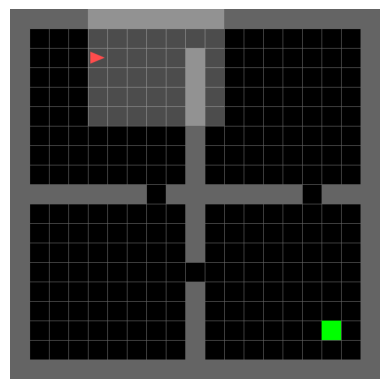

In [10]:
env = FourRoomsEnvPos(agent_pos=(2,2), goal_pos=(16,16))
obs, _ = env.reset(seed=42)
env.step(0)
env.step(2)
obs, _, _, _ = env.step(2)
plt.imshow(env.get_frame())
plt.axis("off")
plt.savefig("./four-rooms/env")

Running MCTS.


100%|██████████| 10000/10000 [02:34<00:00, 64.73it/s]
/tmp/ipykernel_22483/2656413646.py:14: RuntimeWarning: divide by zero encountered in log
  grid = np.log(grid)


MCTS finished.
defaultdict(<function <lambda> at 0x7f06683f95a0>, {((2, 5), 1): 287, ((2, 5), 2): 39, ((2, 4), 1): 1292, ((2, 4), 0): 267, ((2, 4), 3): 51, ((2, 3), 1): 3546, ((2, 3), 2): 1305, ((3, 3), 0): 269, ((2, 3), 0): 1180, ((2, 3), 3): 516, ((2, 2), 3): 2556, ((1, 3), 2): 305, ((2, 4), 2): 252, ((3, 3), 1): 58, ((3, 4), 0): 42, ((2, 5), 0): 29, ((3, 3), 3): 24, ((4, 3), 0): 14, ((1, 3), 3): 30, ((1, 3), 1): 62, ((1, 3), 0): 8, ((2, 2), 2): 3457, ((1, 4), 1): 8, ((1, 4), 2): 17, ((3, 5), 0): 7, ((2, 6), 1): 17, ((2, 5), 3): 7, ((2, 6), 0): 7, ((2, 2), 1): 4338, ((2, 2), 0): 3405, ((1, 2), 2): 1548, ((1, 2), 1): 321, ((1, 2), 0): 87, ((2, 1), 3): 571, ((2, 1), 0): 57, ((3, 2), 0): 1328, ((1, 2), 3): 248, ((1, 1), 3): 30, ((1, 1), 2): 14, ((1, 1), 0): 8, ((2, 1), 2): 42, ((2, 1), 1): 16, ((4, 2), 0): 243, ((3, 2), 3): 239, ((3, 2), 1): 281, ((4, 2), 3): 44, ((3, 1), 3): 22, ((3, 2), 2): 39, ((5, 2), 3): 8, ((5, 2), 1): 7, ((6, 2), 0): 7, ((4, 2), 1): 29, ((5, 2), 0): 14, ((3, 1), 

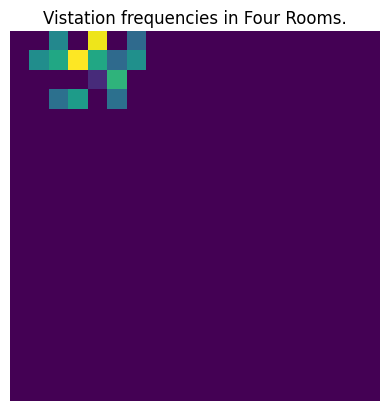

In [29]:
model = FourRoomsModel()
env = FourRoomsEnvPos(agent_pos=(2,2), goal_pos=(16,16))

obs = env.reset(seed=42)
action, root = MCTS(obs, model, {"iters": 10000, "sim_depth": 5}).search()

freqs = unpack_visits(root)
print(freqs)
grid = np.zeros((19, 19))

for loc, visits in freqs.items():
    grid[loc[1], loc[0]] = visits

grid = np.log(grid)
grid[grid == -np.inf] = 0
plt.imshow(grid)
plt.title("Vistation frequencies in Four Rooms.")
plt.axis("off")
plt.savefig("./four-rooms/visits")

# unpack(root, graphviz.Digraph(), set(), action_map=action_map)

In [33]:
graph = unpack(root, graphviz.Digraph(), set(), action_map=action_map)
graph.render("./four-rooms/visit-graph", format="png")

'four-rooms/visit-graph.png'